# KUKA - Document Rectification
This jupyter notebook focus on Perspective rectification and background croping for document type A4,A5
These document may be has background or not ; present full document edges or not



### Reference
- https://dropbox.tech/machine-learning/fast-and-accurate-document-detection-for-scanning
- https://www.microsoft.com/en-us/research/uploads/prod/2016/12/Whiteboard-It.pdf
- https://stackoverflow.com/questions/7263621/how-to-find-corners-on-a-image-using-opencv
- https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

#### History
- 23-05-2023
    - select quadrangle with criterion base on paper: Complex document classifiaction adn localization application on Identity document images

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, 'd:/Project/kuka-py/')
runingPath=os.path.abspath("")
parentPath = Path(runingPath).resolve().parents[0]
if(sys.path[0]!=parentPath):
    sys.path.insert(0, parentPath)

from kukalib.cardcrop  import  *
print(getVersionInfo())

{'version': '0.3.6', 'date': datetime.date(2023, 7, 21)}


## Load image

gray shape: (963, 1280)


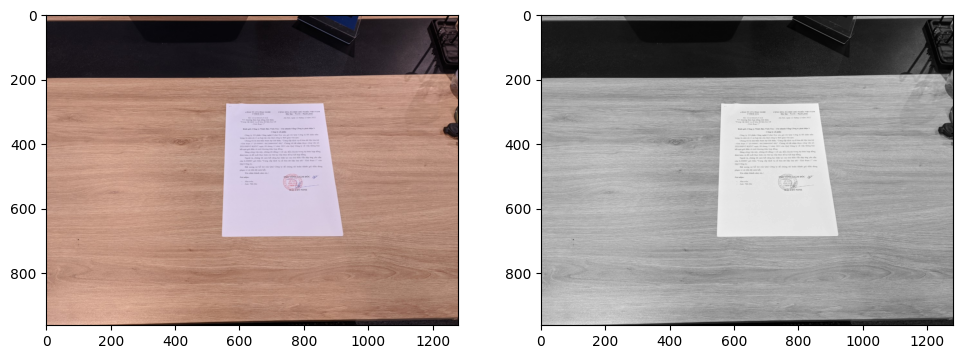

In [25]:
#custom dataset
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_23.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_25.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_10.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_27.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_28.jpg"
filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_ (7).jpg"

#noise
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train2\TB\img (8-1).jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train2\TB\img (32).jpg"

#smartdoc dataset
#filename=r"D:\ImageData\SmartDoc\background01\datasheet001\frame_150.jpg"

#midv500 dataset

#filename=r"D:\ImageData\midv500\01_alb_id\images\TA\TA01_07.tif"
#filename=r"D:\ImageData\midv500\01_alb_id\images\HA\HA01_07.tif"
#filename=r"D:\ImageData\midv500\01_alb_id\images\KA\KA01_07.tif"




src=cv2.imread(filename)

gray=cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

print('gray shape:',gray.shape)
figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.show()

## Step 1: try to extract background
### using Morph_Close to remove text

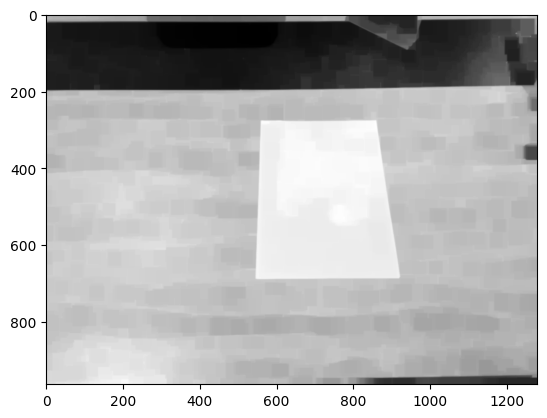

In [26]:
kernel=np.ones((7,7),np.uint8)
dilectImg=cv2.morphologyEx(src,cv2.MORPH_CLOSE,kernel,iterations=5)

gray=cv2.cvtColor(dilectImg,cv2.COLOR_BGR2GRAY)
    
blurImg=cv2.GaussianBlur(gray,(5,5),0)

plt.imshow(blurImg,cmap='gray')
plt.show()

## Step 2: edge and line detect

In [27]:
sobelImg=sobel(blurImg)
#sobelImg=cv2.Canny(blurImg,0,250,apertureSize=3)
ret1,edgeImg = cv2.threshold(sobelImg,40,200, cv2.THRESH_OTSU + cv2.THRESH_TOZERO + cv2.THRESH_BINARY)

## make egde more dilect
edgeImg=cv2.morphologyEx(edgeImg,cv2.MORPH_DILATE,(2,2),iterations=2)

linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)


Num of line hough probility: 72 - shape:  (72, 1, 4)
edgeImg


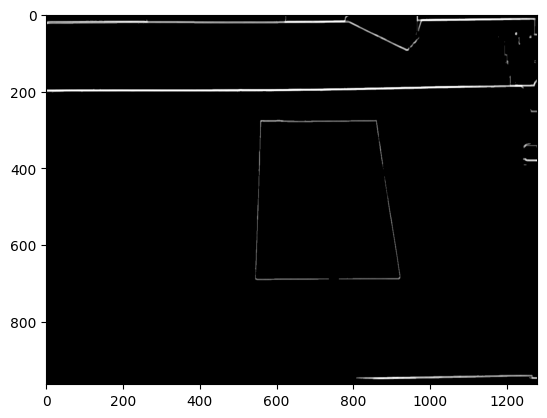

Line image 


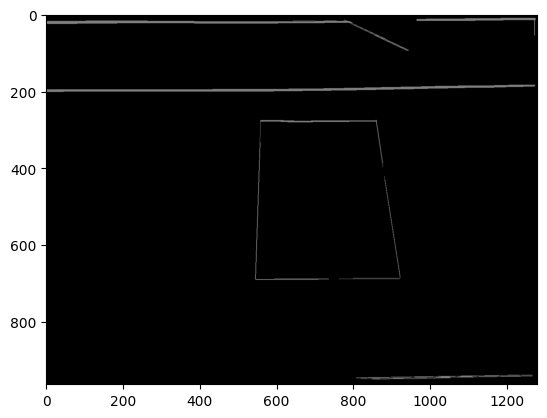

In [28]:
# print debug line
lineImg=np.zeros(src.shape,dtype=np.int8)
if(linesP.any()!=None):
    print('Num of line hough probility:', len(linesP), "- shape: " , linesP.shape )
for line in linesP:
    x1=line[0][0]
    y1=line[0][1]
    x2=line[0][2]
    y2=line[0][3]
    cv2.line(lineImg,(x1,y1),(x2,y2),(255,255,255),1)

print("edgeImg")
plt.imshow(edgeImg,cmap='gray')
plt.show()
#plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
print("Line image ")
plt.imshow(lineImg)
plt.show()

## Step 3: trying to find quadrilateral by estimating 4 lines: top/bottom , left/right
    Asumption:
        - card is nearly center of image
        - 4 edges of card nearly present in the image
    

## Dùng thuật toán đường biên dài nhất
1. Xác dịnh line => dùng houghp đề xác định các line với (x1,y1,x2,y2) => thresold = 1/5 * min(w,h)
2. Clustering lines into groups top / bottom / left/right
2. Fitting line / average line => for each group
    1. chuyển line (x1,y1,x2,y2) => về dạng slopes (b,m)
    2. grouping các line theo (b,m) + khoảng cách giữa các line => được danh sách tham chiếu [line_index] -> [line_in_group]
    3. duyệt theo danh sách tham chiếu => tạo các fitting line
    4. trả lại danh sách sau khi đã fitting
3. Tìm ra quadrangle 
    1. cluster => top/bottom/left/right
    2. soft t/b/l/r line theo length
    3. lấy ra 1 bộ (t,b,l,r) =>lựa chọn quadrangle thỏa mãn các điều kiện về góc va cạnh
- https://sbme-tutorials.github.io/2021/cv/notes/4_week4.html#getting-value-of-rho-and-theta
- https://dsp.stackexchange.com/questions/81992/how-to-convert-a-line-that-goes-through-the-origin-into-hough-space
- https://stackoverflow.com/questions/71811385/how-to-connect-disjointed-lines-or-edges-in-images

Merge line
- https://stackoverflow.com/questions/30746327/get-a-single-line-representation-for-multiple-close-by-lines-clustered-together
- https://answers.opencv.org/question/68781/partition-finding-the-number-of-clusters/


rho_threshold: 5
minline threshold:  50
max_gap_x:  64  max gap y: 48
maxLineGap:  12
minLineLength:  96
total line: 60
edgeImg


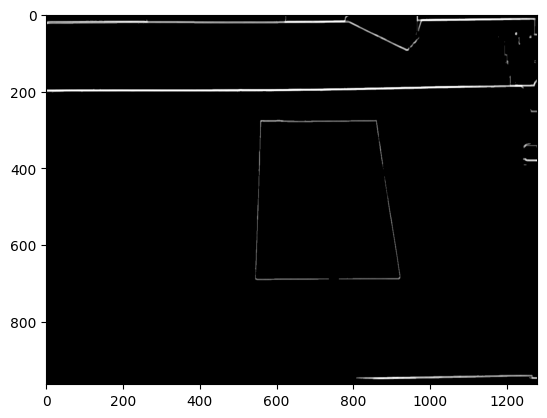

Hough line image


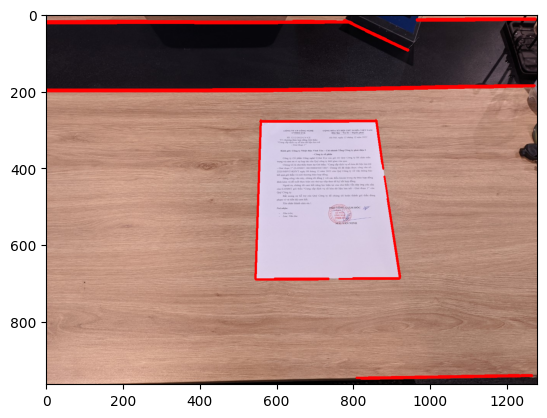

Merged line image


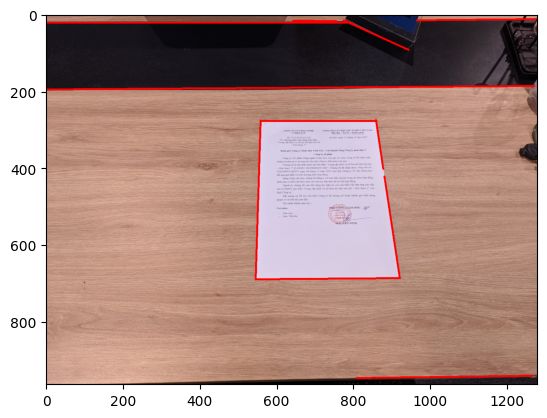

Total merged line:  11
Can not crop document


In [29]:


#def cropDocumentTest():
img_height = gray.shape[0]
img_width=gray.shape[1]

topLineList=[]
bottomLineList=[]
leftLineList=[]
rightLineList=[]

topLine_selected=[]
bottomLine_selected=[]
leftLine_selected=[]
rightLine_selected=[]

#program params
rho_threshold =5 #max(0.005*math.sqrt(img_width*img_width+ img_height*img_height),5)
theta_threshold = 0.5*np.pi/180
max_gap_x = int(0.05*img_width)
max_gap_y = int(0.05*img_height)
minline_threshold  = 50 #int(min(gray.shape[0],gray.shape[1]) /12)
minLineLength =int(0.1*min(img_width,img_height))
maxLineGap = int(0.01*max(img_width,img_height))

print("rho_threshold:",rho_threshold)
print("minline threshold: ",minline_threshold)
print("max_gap_x: ",max_gap_x," max gap y:",max_gap_y)
print("maxLineGap: ",maxLineGap)
print("minLineLength: ",minLineLength)
#get lines by hough
linesP =[]
linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=minline_threshold,minLineLength=minLineLength,maxLineGap=maxLineGap)    
if(not linesP is None and len(linesP)>1):
    print("total line:",len(linesP))

#clustering lines into 4 group
topLineList,bottomLineList,leftLineList,rightLineList=clusteringLineInTBLR(linesP,img_height,img_width)
hasCropped=False
if (len(topLineList)>0 and len(bottomLineList)>0 and len(leftLineList)>0 and len(rightLineList)>0):
    
    # sort line in order befor merging
    topLineList = sortLinePoint(np.squeeze(topLineList,axis=1),sort_axis=0)
    bottomLineList = sortLinePoint( np.squeeze(bottomLineList,axis=1),sort_axis=0)

    leftLineList = sortLinePoint(np.squeeze(leftLineList,axis=1),sort_axis=1)
    rightLineList = sortLinePoint( np.squeeze(rightLineList,axis=1),sort_axis=1)

    #merging
    # convert to slope and merge
    topLineListRhoTheta = convertLinePoint2RhoTheta(topLineList)
    mergedTopLineList = mergingLines(topLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

    bottomLineListRhoTheta = convertLinePoint2RhoTheta(bottomLineList)
    mergedBottomLineList = mergingLines(bottomLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

    leftLineListRhoTheta = convertLinePoint2RhoTheta(leftLineList)
    mergedLeftLineList = mergingLines(leftLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

    rightLineListRhoTheta = convertLinePoint2RhoTheta(rightLineList)
    mergedRightLineList = mergingLines(rightLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

    lineImgDebug = src.copy()
    drawLinePoint(lineImgDebug,topLineList,(0,0,255),3)
    drawLinePoint(lineImgDebug,bottomLineList,(0,0,255),3)
    drawLinePoint(lineImgDebug,leftLineList,(0,0,255),3)
    drawLinePoint(lineImgDebug,rightLineList,(0,0,255),3)


    mergedLineImage = src.copy()
    drawLinePoint(mergedLineImage,mergedTopLineList,(0,0,255),3)
    drawLinePoint(mergedLineImage,mergedBottomLineList,(0,0,255),3)
    drawLinePoint(mergedLineImage,mergedLeftLineList,(0,0,255),3)
    drawLinePoint(mergedLineImage,mergedRightLineList,(0,0,255),3)

    print("edgeImg")
    plt.imshow(edgeImg,cmap='gray')
    plt.show()

    print('Hough line image')
    plt.imshow(cv2.cvtColor(lineImgDebug,cv2.COLOR_BGR2RGB))
    plt.show()

    print('Merged line image')
    plt.imshow(cv2.cvtColor(mergedLineImage,cv2.COLOR_BGR2RGB))
    plt.show()

    totalMergedLine = len(mergedTopLineList) + len(mergedBottomLineList) + len(mergedLeftLineList) + len(mergedRightLineList)
    print ("Total merged line: ",totalMergedLine)
    if(totalMergedLine <500):
        topLine,bottomLine,leftLine,rightLine = getQuadrangleByLength(mergedTopLineList,mergedBottomLineList,mergedLeftLineList,mergedRightLineList,src)
        if(len(topLine)>0 and len(bottomLine)>0 and len(leftLine)>0 and len(rightLine)>0):
            
            #return to debug
            topLine_selected=topLine
            bottomLine_selected = bottomLine
            leftLine_selected = leftLine
            rightLine_selected = rightLine


            cropedImg,lineImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint) = cropImage(src,topLine[0:4],bottomLine[0:4],leftLine[0:4],rightLine[0:4])
            hasCropped=True
            #display to check

            print('selected line image')
            plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
            plt.show()
            
            print('cropped  image')
            plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
            plt.show()
if(not hasCropped):
    print("Can not crop document")
    
    # return topLine_selected,bottomLine_selected,leftLine_selected,rightLine_selected



# Version 2: crop by largest contour
- https://github.com/Fafa-DL/Opencv-project/tree/main/CVZone/07%20Document%20Scanner


In [36]:
pathImage = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_ (4).jpg"


[[[ 645  431]]

 [[ 225  451]]

 [[ 252 1101]]

 [[ 868 1008]]]
[[225, 451], [645, 431], [868, 1008], [252, 1101]]
Area ratio:  0.3505678868120457
Perimeter ratio:  0.5862683905483728


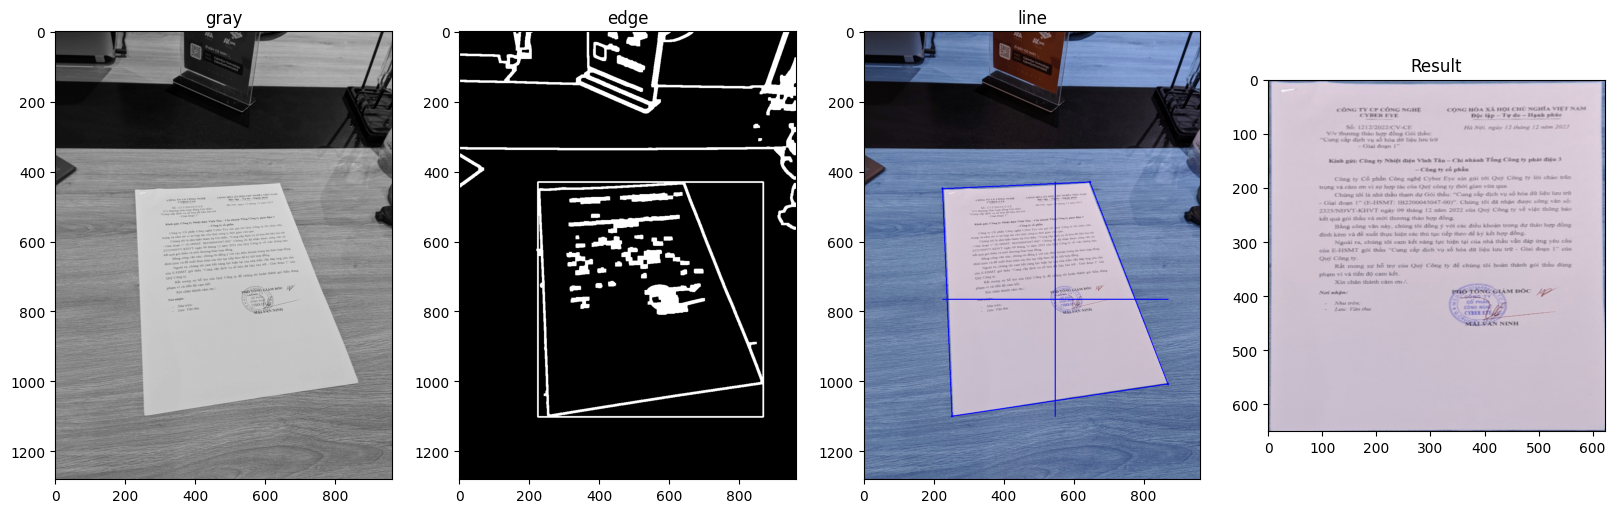

In [37]:
#Method 1: using biggest contour
src = cv2.imread(pathImage)
lineImg = np.zeros(src.shape,dtype=np.uint8)
cropedImg = np.zeros(src.shape,dtype=np.uint8)
hasCropped=False
topleftPoint=[]
toprightPoint=[]
bottomleftPoint=[]
bottomrightPoint=[]


img_height = src.shape[0]
img_width = src.shape[1]

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY) # CONVERT IMAGE TO GRAY SCALE
blurImg = cv2.GaussianBlur(gray, (7, 7), 0) # ADD GAUSSIAN BLUR

edgeImg = cv2.Canny(blurImg,40,200) # APPLY CANNY BLUR
kernel = np.ones((7, 7))
edgeImg = cv2.dilate(edgeImg, kernel, iterations=2) # APPLY DILATION
edgeImg = cv2.erode(edgeImg, kernel, iterations=1)  # APPLY EROSION

## FIND ALL COUNTOURS
contours, hierarchy = cv2.findContours(edgeImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
biggest = biggestContour(contours) # FIND THE BIGGEST CONTOUR

if len(biggest) == 4:
    print(biggest)
    biggest = biggest.reshape(4,2)
    biggest_order = order_points(biggest)
    print(biggest_order)
    x,y,w,h = cv2.boundingRect(np.array(biggest_order).reshape(4,1,2))
    print("Area ratio: ",(w*h)/(img_height*img_width))
    print("Perimeter ratio: ",(w+h)/(img_height+img_width))
    cv2.rectangle(edgeImg,(x,y),(x+w,y+h),(255,255,255),3)

    if(w*h >= 0.33*(img_height*img_width)):
        topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint = biggest_order
        topLine = np.array([topleftPoint,toprightPoint]).reshape(4)
        bottomLine = np.array([bottomleftPoint,bottomrightPoint]).reshape(4)
        leftLine = np.array([topleftPoint,bottomleftPoint]).reshape(4)
        rightLine = np.array([toprightPoint,bottomrightPoint]).reshape(4)
        cropedImg,lineImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint) = cropImage(src,topLine[0:4],bottomLine[0:4],leftLine[0:4],rightLine[0:4])
        hasCropped=True


plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.title("gray")
plt.imshow(gray,cmap='gray')

plt.subplot(1,4,2)
plt.title("edge")
plt.imshow(edgeImg,cmap="gray")

plt.subplot(1,4,3)
plt.title("line")
plt.imshow(lineImg)

plt.subplot(1,4,4)
plt.title("Result")
plt.imshow(cropedImg)

plt.show()
 
    

((224, 450), (645, 431), (868, 1008), (251, 1100))


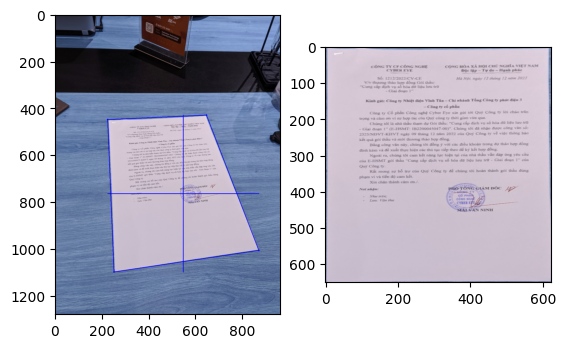

In [38]:
cropedImg,lineImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint),hasCropped =cropDocument(src)
print((topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint))
plt.subplot(1,2,1)
plt.imshow(lineImg)
plt.subplot(1,2,2)
plt.imshow(cropedImg)
plt.show()